# ADD REFERENCES

# Titanic's data analysis and machine learning
## By Jérémy P. Schneider, consultant at IBM interactive

As someone new in this field I decided to take my first challenge with the Titanic dataset from Kaggle (https://www.kaggle.com/c/titanic)

## My OS
For this work I used a computer with :
    * Windows 7
    * Intel(R) Core(TM) i5-2500K CPU @ 3.30GHz
    * 16 Go RAM (4 x 4 Go)
    * NVIDIA GeForce GTX 1050 Ti

This notebook will be split in different part :

## [Setting our environnement :](#ENV)

### [Libraries Import](#lib)
### [Personnalized functions and tools](#func)
### [Data import](#import)

## [Data cleaning and analysis :](#CLEAN)
### [Data analysis](#analysis)
### [Handeling missing data](#MISSING)
### [Converting all data in number](#convert)


## [Test and train a model](#test_train)

## [Conclusion and trial over the test sample](#conclusion)

<a id="ENV"></a>
# Setting our environnement
<a id="lib"></a>
## Libraries Import

In [25]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import numpy as np
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix

<a id="func"></a>
## Personnalized functions and tools

Since the Titanic dataset contains name with Title, I used the idea of Ertuğrul Demir to create a dictionnary to remplace them (https://www.kaggle.com/datafan07/titanic-eda-and-several-modelling-approaches)

In [2]:
dict_title = {
    'Capt': 'Dr/Clerc/Mil',
    'Col': 'Dr/Clerc/Mil',
    'Major': 'Dr/Clerc/Mil',
    'Jonkheer': 'Honor',
    'Don': 'Honor',
    'Dona': 'Honor',
    'Sir': 'Honor',
    'Dr': 'Dr/Clerc/Mil',
    'Rev': 'Dr/Clerc/Mil',
    'the Countess': 'Honor',
    'Mme': 'Mrs',
    'Mlle': 'Miss',
    'Ms': 'Mrs',
    'Mr': 'Mr',
    'Mrs': 'Mrs',
    'Miss': 'Miss',
    'Master': 'Master',
    'Lady': 'Honor'
}

def extractTitle(df, nameCol, dictTitle):
    '''
    extractTitle(df, nameCol, dictTitle)
    Input : df : dataframe, will be copied.
            nameCol : name of the columns where to extract titles.
            dictTitle : dictionary of title and their conversion.
    This fonction extract title from a specific column with a custom dict and remove nameCol.
    '''
    
    df_new = df.copy()
    df_new["Title"] = ""
    for row in range(df_new.shape[0]):
        name = df_new.loc[row][nameCol]
        for title in dictTitle:
            if title in name:
                df_new["Title"][row] = dictTitle[title]
    return df_new.drop([nameCol], axis=1)

def getDummiesTitanic(df, dummies):
    '''
    getDummiesTitanic(df, dummies)
    Input : df : dataframe, will be copied.
            dummies : list of dummies to transform.
            dictTitle : dictionary of title and their conversion
    This fonction get dummies for a given list and drop the original column.
    '''
    df_new = df.copy()
    for dummy in dummies:
        try :
            df_new = df_new.join(pd.get_dummies(df_new[dummy], prefix = dummy))
            df_new = df_new.drop([dummy], axis=1)
        except KeyError:
            print("Warning : column {} is missing".format(dummy))
        
    return df_new

<a id="import"></a>
## Data import

In [3]:
df_train_org = pd.read_csv("data/train.csv")
df_test_org = pd.read_csv("data/test.csv")

<a id="CLEAN"></a>
# Data cleaning and analysis

<a id="analysis"></a>
## Data analysis

From Kaggle we know how the data is ordered and it define our goal :

The data has been split into two groups:

    training set (train.csv)
    test set (test.csv)

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

### Data Dictionary

|Variable	    |Definition	        |Key
| ------------- |:-----------------:| -----:|
|survival 	    |Survival 	        |0 = No, 1 = Yes
|pclass 	    |Ticket class 	    |1 = 1st, 2 = 2nd, 3 = 3rd
|sex 	        |Sex 	
|Age 	        |Age in years 	
|sibsp 	        |# of siblings / spouses aboard the Titanic 	
|parch 	        |# of parents / children aboard the Titanic 	
|ticket         |Ticket number 	
|fare 	        |Passenger fare 	
|cabin 	        |Cabin number 	
|embarked 	    |Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton

### Variable Notes

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

If we watch how the data is in our ile, wa saw that the information is correct.

* First the train data



In [4]:
df_train_org.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [5]:
print("In the train data we have {} rows and {} columns".format(df_train_org.shape[0], df_train_org.shape[1]))

In the train data we have 891 rows and 12 columns


* Then the test data

In [6]:
df_test_org.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [7]:
print("In the test data we have {} rows and {} columns".format(df_test_org.shape[0], df_test_org.shape[1]))

In the test data we have 418 rows and 11 columns


As we see the two set have the same topology :
* int and float for numerical values.
* object for text data.

We'll need to transform the text data in numerical values in order to feed our machine learning model.

### Checking correlation

We first remplace __Sex__ and __Embarked__ with numerical values based on the occurencies on the train data. 

Since we don't want to have biais we won't look too deep in the test data.

In [8]:
df_train_org["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [9]:
df_train_org["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [10]:
df_train = df_train_org.copy()
df_train["SexNum"] = df_train["Sex"]
df_train["SexNum"].loc[df_train["SexNum"] == "male"] = 1
df_train["SexNum"].loc[df_train["SexNum"] == "female"] = 0

df_train["EmbarkedNum"] = df_train["Embarked"]
df_train["EmbarkedNum"] = df_train["EmbarkedNum"].fillna(0)
df_train["EmbarkedNum"].loc[df_train["EmbarkedNum"] == "S"] = 2
df_train["EmbarkedNum"].loc[df_train["EmbarkedNum"] == "C"] = 1
df_train["EmbarkedNum"].loc[df_train["EmbarkedNum"] == "Q"] = 0
df_train["EmbarkedNum"] = df_train["EmbarkedNum"].astype(int)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Then we compute the correlation

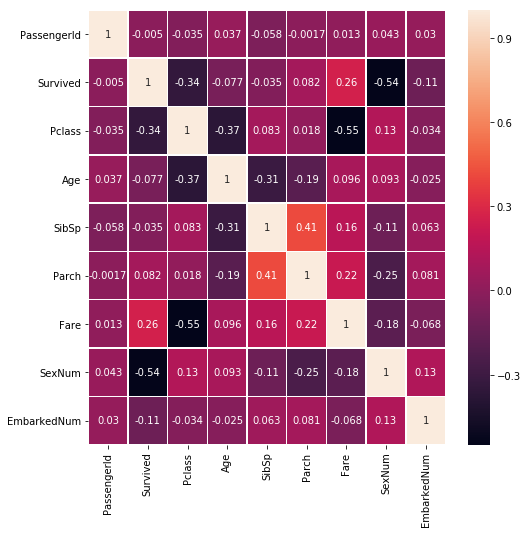

This graphic took me : 00:00:00


In [11]:
start_time = time.time()
plt.figure(figsize=(8,8))
sns.heatmap(df_train.corr(), annot=True, linewidths=.5, annot_kws={"size":10})
plt.show()
elapsed_time = time.time() - start_time
print("This graphic took me : {}".format(time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))

We can se that we have :
* a weak neagtive correlation between __Fare__ and __Pclass__ : 1st class have more money than 3rd
* a weak positive correlation between __SibSp__ and __Survived__ : It appears that people  with more family on board survived more. It's confirm by the other weak correlation between __Parch__ and __Survived__.

<a id="MISSING"></a>
### Handeling missing data

After checking the type of the data we use, we need to see where missing values are, to do so we can simply calculated them this way :

In [12]:
df_train_org.isna().mean()

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

In [13]:
df_test_org.isna().mean()

PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.205742
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.002392
Cabin          0.782297
Embarked       0.000000
dtype: float64

From this step we know :
* __Cabin__ information is missing in more than 75% of our data, so we'll not use it.
* __Age__ information is missing at 20% of the time, we'll try to remplace the missing values
* __Embarked__ information is missing several values in the trainset
* __Fare__ information is missing serveral values in the testset

We can use three method to take care of the missing data points
* Remove columns

In [14]:
df_train_remove = df_train_org.drop(["Cabin", "Age", "Embarked", "Fare"], axis=1)
df_test_remove = df_test_org.drop(["Cabin", "Age", "Embarked", "Fare"], axis=1)

* Compute MEAN for numerical, and most occurent for categorical

For Embarked we take at look at the data

In [15]:
df_train["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [16]:
start_time = time.time()
df_train_mean = df_train_org.drop(["Cabin"], axis=1).copy()
df_train_mean["Age"] = df_train_mean["Age"].fillna(df_train_mean["Age"].mean())
df_train_mean["Embarked"] = df_train_mean["Embarked"].fillna("S")
df_test_mean = df_test_org.drop(["Cabin"], axis=1).copy()
df_test_mean["Age"] = df_test_mean["Age"].fillna(df_test_mean["Age"].mean())
df_test_mean["Fare"] = df_test_mean["Fare"].fillna(df_test_mean["Fare"].mean())
elapsed_time = time.time() - start_time
print("This calculations took me : {}".format(time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))

This calculations took me : 00:00:00


In [17]:
df_train_mean.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

* Compute MEDIAN for numerical and most occurent for categorical

In [18]:
df_train_median = df_train_org.drop(["Cabin"], axis=1).copy()
df_train_median["Age"] = df_train_median["Age"].fillna(df_train_median["Age"].median())
df_train_median["Embarked"] = df_train_median["Embarked"].fillna("S")
df_test_median = df_test_org.drop(["Cabin"], axis=1).copy()
df_test_median["Age"] = df_test_median["Age"].fillna(df_test_median["Age"].median())
df_test_median["Fare"] = df_test_median["Fare"].fillna(df_test_median["Fare"].median())

<a id="convert"></a>
### Converting all data in number

We'll first take care of the name column. We'll extract the title from the names. (REF)

The steps are :
* Create a new column
* Read each names
* Check if any title exist in the name
* Add the title in the new column

We'll need to do it on all our datasets, so we can use the fonction defined before.

In [19]:
start_time = time.time()
df_train_remove = extractTitle(df_train_remove, "Name", dict_title)
df_test_remove = extractTitle(df_test_remove, "Name", dict_title)
df_train_mean = extractTitle(df_train_mean, "Name", dict_title)
df_test_mean = extractTitle(df_test_mean, "Name", dict_title)
df_train_median = extractTitle(df_train_median, "Name", dict_title)
df_test_median = extractTitle(df_test_median, "Name", dict_title)
elapsed_time = time.time() - start_time
print("This calculations took me : {}".format(time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


This calculations took me : 00:02:34


One of the most current way to deal with categorical data is to <i>get dummies</i> (REF)

In [20]:
df_train_remove.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Ticket,Title
0,1,0,3,male,1,0,A/5 21171,Mr
1,2,1,1,female,1,0,PC 17599,Mrs
2,3,1,3,female,0,0,STON/O2. 3101282,Miss
3,4,1,1,female,1,0,113803,Mrs
4,5,0,3,male,0,0,373450,Mr


In [21]:
start_time = time.time()
list_dummies = ["Sex", "Embarked", "Title"]

df_train_remove = getDummiesTitanic(df_train_remove, list_dummies)
df_test_remove = getDummiesTitanic(df_test_remove, list_dummies)
df_train_mean = getDummiesTitanic(df_train_mean, list_dummies)
df_test_mean = getDummiesTitanic(df_test_mean, list_dummies)
df_train_median = getDummiesTitanic(df_train_median, list_dummies)
df_test_median = getDummiesTitanic(df_test_median, list_dummies)
elapsed_time = time.time() - start_time
print("This calculations took me : {}".format(time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))

This calculations took me : 00:00:00


In [22]:
df_train_remove.head()

,PassengerId,Survived,Pclass,SibSp,Parch,Ticket,Sex_female,Sex_male,Title_Dr/Clerc/Mil,Title_Honor,Title_Master,Title_Miss,Title_Mr,Title_Mrs
0,1,0,3,1,0,A/5 21171,0,1,0,0,0,0,1,0
1,2,1,1,1,0,PC 17599,1,0,0,0,0,0,0,1
2,3,1,3,0,0,STON/O2. 3101282,1,0,0,0,0,1,0,0
3,4,1,1,1,0,113803,1,0,0,0,0,0,0,1
4,5,0,3,0,0,373450,0,1,0,0,0,0,1,0


At this point, I only have the __Ticket__ left as non-numerical value. In the dataset there is 681 uniques tickets values. It doesn't seem to bring any information, compare to __Embarked__ which is the port where they start their journey, so I decided to remove it.

In [23]:
df_train_remove = df_train_remove.drop(["Ticket"], axis=1)
df_test_remove = df_test_remove.drop(["Ticket"], axis=1)
df_train_mean = df_train_mean.drop(["Ticket"], axis=1)
df_test_mean = df_test_mean.drop(["Ticket"], axis=1)
df_train_median = df_train_median.drop(["Ticket"], axis=1)
df_test_median = df_test_median.drop(["Ticket"], axis=1)

<a id="test_train"></a>
## Test and train a model

First we need to split the datasets in train and test. The mesure the preformance of our models.

We also create a dict to record all the scores.

In [24]:
X_train_remove, X_test_remove, y_train_remove, y_test_remove = train_test_split(df_train_remove.drop(["Survived"], axis=1), 
                                                               df_train_remove["Survived"], 
                                                               test_size=0.2,
                                                               random_state=0)

X_train_mean, X_test_mean, y_train_mean, y_test_mean = train_test_split(df_train_mean.drop(["Survived"], axis=1), 
                                                       df_train_mean["Survived"], 
                                                       test_size=0.2,
                                                       random_state=0)
X_train_median, X_test_median, y_train_median, y_test_median = train_test_split(df_train_median.drop(["Survived"], axis=1), 
                                                               df_train_median["Survived"], 
                                                               test_size=0.2,
                                                               random_state=0)


SCORES = {"Remove":{},"Mean":{},"Median":{}}

### With the SVM (Support Vector Machines (REF)) :

* If we use the df_train_remove :

In [26]:
start_time = time.time()
clf = svm.SVC(kernel='linear', C = 1.0) #Check other models
clf.fit(X_train_remove, y_train_remove)
y_pred_remove = clf.predict(X_test_remove)

print(confusion_matrix(y_test_remove, y_pred_remove))
score = (((y_pred_remove == y_test_remove).sum())/y_test_remove.shape[0])
score = round(score*100,2)
SCORES["Remove"]["SVM"] = score
print("Perfomace is : {}% for SVM_Remove".format(score))
elapsed_time = time.time() - start_time
print("This calculations took me : {}".format(time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))

[[93 17]
 [18 51]]
Perfomace is : 80.45% for SVM_Remove
This calculations took me : 00:00:03


* If we use the df_train_mean

In [27]:
start_time = time.time()
clf.fit(X_train_mean, y_train_mean)
y_pred_mean = clf.predict(X_test_mean)

print(confusion_matrix(y_test_mean, y_pred_mean))
score = (((y_pred_mean == y_test_mean).sum())/y_test_mean.shape[0])
score = round(score*100,2)
SCORES["Mean"]["SVM"] = score
print("Perfomace is : {}% for SVM_Mean".format(score))
elapsed_time = time.time() - start_time
print("This calculations took me : {}".format(time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))

[[94 16]
 [18 51]]
Perfomace is : 81.01% for SVM_Mean
This calculations took me : 00:00:25


* If we use the df_train_median

In [28]:
start_time = time.time()
clf.fit(X_train_median, y_train_median)
y_pred_median = clf.predict(X_test_median)

print(confusion_matrix(y_test_median, y_pred_median))
score = (((y_pred_median == y_test_median).sum())/y_test_median.shape[0])
score = round(score*100,2)
SCORES["Median"]["SVM"] = score
print("Perfomace is : {}% for SVM_Median".format(score))
elapsed_time = time.time() - start_time
print("This calculations took me : {}".format(time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))

[[94 16]
 [18 51]]
Perfomace is : 81.01% for SVM_Median
This calculations took me : 00:00:24


In [29]:
SCORES

{'Remove': {'SVM': 80.45}, 'Mean': {'SVM': 81.01}, 'Median': {'SVM': 81.01}}

# GridSearch to optimized Hyperparameters
The results with basic parameters for SVM are not bad, but we can find better hyperparameters with GridSearch.

In [ ]:
# defining parameter range 
start_time = time.time()
param_grid = {"C": [0.1, 1, 10, 100, 1000],  
              "gamma": [1, 0.1, 0.01, 0.001, 0.0001], 
              "degree" : [1,2,3,4,5,6,7,8,9,10],
              "kernel": ["rbf", "linear", "poly"]}  
grid = GridSearchCV(svm.SVC(), param_grid, refit = True)
grid.fit(X_train_remove, y_train_remove) 
print("The best parameters are : {} with removed features".format(grid.best_params_))
print("This calculations took me : {}".format(time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


### With the KNeighborsClassifier (REF)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
print("Train/Test/Record for df_train_remove")
knn.fit(X_train_remove, y_train_remove)
y_pred_remove = knn.predict(X_test_remove)
print(confusion_matrix(y_test_remove, y_pred_remove))
score = (((y_pred_remove == y_test_remove).sum())/y_test_remove.shape[0])
score = round(score*100,2)
SCORES["Remove"]["KNN_3"] = score
print("Perfomace is : {}% for KNN_3_Remove".format(score))
print("Train/Test/Record for df_train_mean")
knn.fit(X_train_mean, y_train_mean)
y_pred_mean = knn.predict(X_test_mean)
print(confusion_matrix(y_test_mean, y_pred_mean))
score = (((y_pred_mean == y_test_mean).sum())/y_test_mean.shape[0])
score = round(score*100,2)
SCORES["Mean"]["KNN_3"] = score
print("Perfomace is : {}% for KNN_3_Mean".format(score))
print("Train/Test/Record for df_train_median")
knn.fit(X_train_median, y_train_median)
y_pred_median = knn.predict(X_test_median)
print(confusion_matrix(y_test_median, y_pred_median))
score = (((y_pred_median == y_test_median).sum())/y_test_median.shape[0])
score = round(score*100,2)
SCORES["Median"]["KNN_3"] = score
print("Perfomace is : {}% for KNN_3_Median".format(score))

In [ ]:
SCORES

# Trying differents Neighbors

In [ ]:
for i in range(1,101):
    knn = KNeighborsClassifier(n_neighbors=i)
    print("Train/Test/Record for df_train_remove")
    knn.fit(X_train_remove, y_train_remove)
    y_pred_remove = knn.predict(X_test_remove)
    print(confusion_matrix(y_test_remove, y_pred_remove))
    score = (((y_pred_remove == y_test_remove).sum())/y_test_remove.shape[0])
    score = round(score*100,2)
    KNN = "KNN_" + str(i)
    SCORES["Remove"][KNN] = score
    print("Perfomace is : {}% for {}_Remove".format(score,KNN))
    print("Train/Test/Record for df_train_mean")
    knn.fit(X_train_mean, y_train_mean)
    y_pred_mean = knn.predict(X_test_mean)
    print(confusion_matrix(y_test_mean, y_pred_mean))
    score = (((y_pred_mean == y_test_mean).sum())/y_test_mean.shape[0])
    score = round(score*100,2)
    SCORES["Mean"][KNN] = score
    print("Perfomace is : {}% for {}_Mean".format(score,KNN))
    print("Train/Test/Record for df_train_median")
    knn.fit(X_train_median, y_train_median)
    y_pred_median = knn.predict(X_test_median)
    print(confusion_matrix(y_test_median, y_pred_median))
    score = (((y_pred_median == y_test_median).sum())/y_test_median.shape[0])
    score = round(score*100,2)
    SCORES["Median"][KNN] = score
    print("Perfomace is : {}% for {}_Median".format(score,KNN))

In [ ]:
SCORES

In [ ]:
res = {key: SCORES[key] for key in SCORES.keys() 
                               & {'akshat', 'nikhil'}} 

In [ ]:
# GRID SEARCH from SKLEARN